In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import torchvision
import numpy as np
from torch.autograd import Variable
from torch.optim import lr_scheduler
import argparse

import time
import copy
from torchvision.utils import save_image

from scipy.io import savemat
from scipy.io import loadmat
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd /content/drive/MyDrive/ProjectB

/content/drive/MyDrive/ProjectB


In [ ]:
from networks import MLP, ConvNet, LeNet, AlexNet, AlexNetBN, VGG11, VGG11BN, ResNet18, ResNet18BN_AP, ResNet18BN
from utils import get_loops, get_dataset, get_network, get_eval_pool, evaluate_synset, get_daparam, match_loss, get_time, TensorDataset, epoch, DiffAugment, ParamDiffAug

# Dataset Condensation and Visualization

In [ ]:
parser = argparse.ArgumentParser(description='Parameter Processing')
parser.add_argument('--method', type=str, default='DC', help='DC/DSA')
parser.add_argument('--dataset', type=str, default='CIFAR10', help='dataset')
parser.add_argument('--model', type=str, default='ConvNet', help='model')
parser.add_argument('--ipc', type=int, default=10, help='image(s) per class')
parser.add_argument('--eval_mode', type=str, default='S', help='eval_mode') # S: the same to training model, M: multi architectures,  W: net width, D: net depth, A: activation function, P: pooling layer, N: normalization layer,
parser.add_argument('--num_exp', type=int, default=5, help='the number of experiments')
parser.add_argument('--num_eval', type=int, default=20, help='the number of evaluating randomly initialized models')
parser.add_argument('--epoch_eval_train', type=int, default=300, help='epochs to train a model with synthetic data')
parser.add_argument('--Iteration', type=int, default=100, help='training iterations')
parser.add_argument('--lr_img', type=float, default=0.1, help='learning rate for updating synthetic images')
parser.add_argument('--lr_net', type=float, default=0.01, help='learning rate for updating network parameters')
parser.add_argument('--batch_real', type=int, default=256, help='batch size for real data')
parser.add_argument('--batch_train', type=int, default=256, help='batch size for training networks')
parser.add_argument('--init', type=str, default='noise', help='noise/real: initialize synthetic images from random noise or randomly sampled real images.')
parser.add_argument('--dsa_strategy', type=str, default='None', help='differentiable Siamese augmentation strategy')
parser.add_argument('--data_path', type=str, default='data', help='dataset path')
parser.add_argument('--save_path', type=str, default='result', help='path to save results')
parser.add_argument('--dis_metric', type=str, default='ours', help='distance metric')
parser.add_argument('--std', type=float, default=0.3081)
parser.add_argument('--mean', type=float, default=0.1307)

args, unknown = parser.parse_known_args()
# args.init = 'real'
# mean = [0.1307]
# std = [0.3081]
args.dataset = 'MNIST'
args.outer_loop, args.inner_loop = get_loops(args.ipc)
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.dsa_param = ParamDiffAug()
args.dsa = True if args.method == 'DSA' else False

if not os.path.exists(args.data_path):
  os.mkdir(args.data_path)

if not os.path.exists(args.save_path):
  os.mkdir(args.save_path)

channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset(args.dataset, args.data_path)

''' organize the real dataset '''
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
labels_all = [dst_train[i][1] for i in range(len(dst_train))]

for i, lab in enumerate(labels_all):
  indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(args.device)
labels_all = torch.tensor(labels_all, dtype=torch.long, device=args.device)

for c in range(num_classes):
  print('class c = %d: %d real images'%(c, len(indices_class[c])))

def get_images(c, n): # get random n images from class c
  idx_shuffle = np.random.permutation(indices_class[c])[:n]
  return images_all[idx_shuffle]
# print(images_all[0])

for ch in range(channel):
  print('real images channel %d, mean = %.4f, std = %.4f'%(ch, torch.mean(images_all[:, ch]), torch.std(images_all[:, ch])))


''' initialize the synthetic data '''
image_syn = torch.randn(size=(num_classes*args.ipc, channel, im_size[0], im_size[1]), dtype=torch.float, requires_grad=True, device=args.device)
label_syn = torch.tensor([np.ones(args.ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=args.device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]

if args.init == 'real':
  print('initialize synthetic data from random real images')
  for c in range(num_classes):
    image_syn.data[c*args.ipc:(c+1)*args.ipc] = get_images(c, args.ipc).detach().data
else:
  print('initialize synthetic data from random noise')

''' training '''
optimizer_img = torch.optim.SGD([image_syn, ], lr=args.lr_img, momentum=0.5) # optimizer_img for synthetic data
optimizer_img.zero_grad()
criterion = nn.CrossEntropyLoss().to(args.device)
print('%s training begins'%get_time())


for it in range(args.Iteration+1):
  

  ''' Train synthetic data '''
  net = get_network(args.model, channel, num_classes, im_size).to(args.device) # get a random model
  net.train()
  net_parameters = list(net.parameters())
  optimizer_net = torch.optim.SGD(net.parameters(), lr=args.lr_net)  # optimizer_img for synthetic data
  optimizer_net.zero_grad()
  loss_avg = 0
  args.dc_aug_param = None  # Mute the DC augmentation when learning synthetic data (in inner-loop epoch function) in oder to be consistent with DC paper.
  
  for ol in range(args.outer_loop): # ol = 10, il = 50 (T)

    ''' update synthetic data '''
    loss = torch.tensor(0.0).to(args.device)
    for c in range(num_classes):
      img_real = get_images(c, args.batch_real)
      lab_real = torch.ones((img_real.shape[0],), device=args.device, dtype=torch.long) * c
      img_syn = image_syn[c*args.ipc:(c+1)*args.ipc].reshape((args.ipc, channel, im_size[0], im_size[1]))
      lab_syn = torch.ones((args.ipc,), device=args.device, dtype=torch.long) * c
      
      output_real = net(img_real)
      loss_real = criterion(output_real, lab_real)
      gw_real = torch.autograd.grad(loss_real, net_parameters)
      gw_real = list((_.detach().clone() for _ in gw_real))

      output_syn = net(img_syn)
      loss_syn = criterion(output_syn, lab_syn)
      gw_syn = torch.autograd.grad(loss_syn, net_parameters, create_graph=True)

      loss += match_loss(gw_syn, gw_real, args)

    optimizer_img.zero_grad()
    loss.backward()
    optimizer_img.step()
    loss_avg += loss.item()

    if ol == args.outer_loop - 1:
      break

      ''' update network '''
      image_syn_train, label_syn_train = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())  # avoid any unaware modification
      dst_syn_train = TensorDataset(image_syn_train, label_syn_train)
      trainloader = torch.utils.data.DataLoader(dst_syn_train, batch_size=args.batch_train, shuffle=True, num_workers=0)
      for il in range(args.inner_loop):
        epoch('train', trainloader, net, optimizer_net, criterion, args, aug = True if args.dsa else False)
  loss_avg /= (num_classes*args.outer_loop)
  

  if it%10 == 0:
    print('%s iter = %04d, loss = %.4f' % (get_time(), it, loss_avg))
    
    ''' Test '''  
    accs = []
    image_syn_eval, label_syn_eval = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach()) # avoid any unaware modification
    _, acc_train, acc_test = evaluate_synset(1, net, image_syn_eval, label_syn_eval, testloader, args)
    accs.append(acc_test)

class c = 0: 5923 real images
class c = 1: 6742 real images
class c = 2: 5958 real images
class c = 3: 6131 real images
class c = 4: 5842 real images
class c = 5: 5421 real images
class c = 6: 5918 real images
class c = 7: 6265 real images
class c = 8: 5851 real images
class c = 9: 5949 real images
real images channel 0, mean = -0.0001, std = 1.0000
initialize synthetic data from random noise
[2022-12-10 01:11:19] training begins


<ipython-input-5-c8d34ac6e531>:68: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label_syn = torch.tensor([np.ones(args.ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=args.device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]
<ipython-input-5-c8d34ac6e531>:68: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  label_syn = torch.tensor([np.ones(args.ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=args.device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]


[2022-12-10 01:11:30] iter = 0000, loss = 230.9585
[2022-12-10 01:11:36] Evaluate_01: epoch = 0300 train time = 3 s train loss = 0.004447 train acc = 1.0000, test acc = 0.5542
[2022-12-10 01:12:16] iter = 0010, loss = 97.6444
[2022-12-10 01:12:22] Evaluate_01: epoch = 0300 train time = 3 s train loss = 0.004088 train acc = 1.0000, test acc = 0.8201
[2022-12-10 01:13:02] iter = 0020, loss = 70.3572
[2022-12-10 01:13:07] Evaluate_01: epoch = 0300 train time = 3 s train loss = 0.003620 train acc = 1.0000, test acc = 0.8331
[2022-12-10 01:13:47] iter = 0030, loss = 51.5216
[2022-12-10 01:13:53] Evaluate_01: epoch = 0300 train time = 3 s train loss = 0.003492 train acc = 1.0000, test acc = 0.8516
[2022-12-10 01:14:32] iter = 0040, loss = 41.9978
[2022-12-10 01:14:38] Evaluate_01: epoch = 0300 train time = 3 s train loss = 0.003372 train acc = 1.0000, test acc = 0.8617
[2022-12-10 01:15:17] iter = 0050, loss = 38.1789
[2022-12-10 01:15:23] Evaluate_01: epoch = 0300 train time = 3 s train los

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]


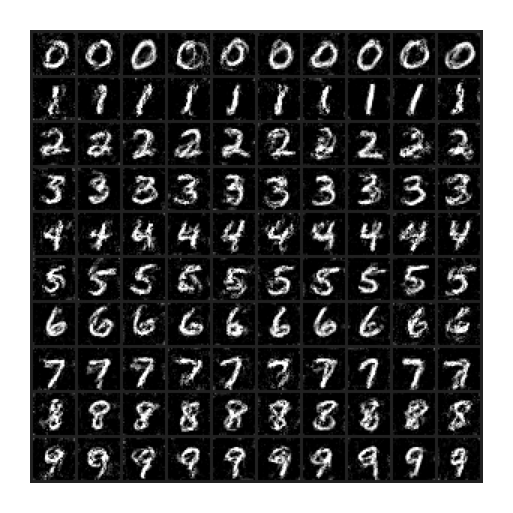

In [ ]:
# images, labels = next(iter(data_loader_train))
dataset_syn = torchvision.utils.make_grid(image_syn, nrow=10).cpu()
dataset_syn = dataset_syn.numpy().transpose(1,2,0)
dataset_syn = dataset_syn*args.std+args.mean
print([int(label_syn[i]) for i in range(100)])

plt.figure(dpi=300,figsize=(2,2))
plt.axis('off')
plt.imshow(dataset_syn)
os.chdir('/content/drive/MyDrive/ProjectB/Figures')
plt.savefig('MNIST_syn_Gaussian.jpg',dpi=300)
os.chdir('/content/drive/MyDrive/ProjectB/Results')
IMG_dict={'dataset_syn':dataset_syn, 'label_syn':label_syn}
savemat('MNIST_Gaussian.mat',IMG_dict)

# Train from Scratch and Test

In [ ]:
data_train = TensorDataset(image_syn.to('cpu'), label_syn.to('cpu'))
trainloader = torch.utils.data.DataLoader(data_train, batch_size=256, shuffle=True, num_workers=2)
# print(len(data_train))

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=args.mean, std=args.std)])

data_test = datasets.MNIST(root="./data/",
               transform = transform,
               train = False)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                         batch_size = 256,
                         shuffle = True,
                         num_workers=2)

net = get_network('ConvNet', 1 , num_classes = 10, im_size=(28, 28))
net = net.to('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()
net_parameters = list(net.parameters())
optimizer_net = torch.optim.SGD(net.parameters(),lr=0.01,momentum=0.9)  # optimizer_img for synthetic data
scheduler = lr_scheduler.CosineAnnealingLR(optimizer_net,40)
num_epochs = 20

In [ ]:
accuracy_test = []
accuracy_train = []
t_all = 0
for epoch in range(num_epochs):
  net.train(True) # Train mode 
  loss_tot = 0.0
  correct_tot = 0
  print("Epoch {}/{}".format(epoch, num_epochs))
  print("-"*10)
  t0 = time.time()
  for data in trainloader:
    imgs, labels = data
    imgs = imgs.to('cuda' if torch.cuda.is_available() else 'cpu')
    labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer_net.zero_grad() # clear the grad
    outputs = net(imgs) # forward
    loss = criterion(outputs,labels) # loss calculation
    pred = torch.argmax(outputs,dim=1)
    loss_tot += loss.data
    correct_tot += torch.sum(pred == labels.data)
    loss.backward()
    optimizer_net.step()
  scheduler.step()
  t1 = time.time()
    
  net.train(False)
  testing_correct = 0
  for data in data_loader_test:
    img_test, label_test = data
    img_test = img_test.to('cuda' if torch.cuda.is_available() else 'cpu')
    label_test = label_test.to('cuda' if torch.cuda.is_available() else 'cpu')
    outputs = net(img_test)
    pred = torch.argmax(outputs,dim=1)
    testing_correct += torch.sum(pred == label_test.data)
  accuracy_test.append(100*testing_correct/len(data_test))
  accuracy_train.append(100*correct_tot/len(data_train))
  print("Loss is:{:.4f}, Train Accuracy is:{:.4f}%, Test Accuracy is:{:.4f}%".format(loss_tot/len(data_train),
                                           100*correct_tot/len(data_train),
                                           100*testing_correct/len(data_test)))
  t_all = t_all+(t1-t0)
print(t_all)


Epoch 0/20
----------
Loss is:0.0236, Train Accuracy is:6.0000%, Test Accuracy is:21.7800%
Epoch 1/20
----------
Loss is:0.0221, Train Accuracy is:30.0000%, Test Accuracy is:43.8100%
Epoch 2/20
----------
Loss is:0.0205, Train Accuracy is:54.0000%, Test Accuracy is:48.4400%
Epoch 3/20
----------
Loss is:0.0187, Train Accuracy is:60.0000%, Test Accuracy is:70.5000%
Epoch 4/20
----------
Loss is:0.0165, Train Accuracy is:82.0000%, Test Accuracy is:77.5500%
Epoch 5/20
----------
Loss is:0.0145, Train Accuracy is:93.0000%, Test Accuracy is:73.7700%
Epoch 6/20
----------
Loss is:0.0129, Train Accuracy is:87.0000%, Test Accuracy is:78.6400%
Epoch 7/20
----------
Loss is:0.0111, Train Accuracy is:96.0000%, Test Accuracy is:82.3500%
Epoch 8/20
----------
Loss is:0.0094, Train Accuracy is:97.0000%, Test Accuracy is:82.0000%
Epoch 9/20
----------
Loss is:0.0081, Train Accuracy is:94.0000%, Test Accuracy is:82.7200%
Epoch 10/20
----------
Loss is:0.0069, Train Accuracy is:95.0000%, Test Accuracy 

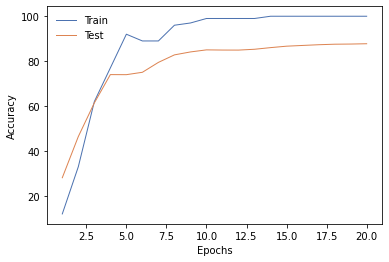

In [ ]:
# Plot the accuracy vs. epochs curve
color_list = sns.color_palette('deep')
accuracy_test = [accuracy_test[i].cpu() for i in range(num_epochs)]
accuracy_train = [accuracy_train[i].cpu() for i in range(num_epochs)]
# plot
plt.plot(range(1,num_epochs+1),accuracy_train,linewidth=1,color = color_list[0],label='Train')
plt.plot(range(1,num_epochs+1),accuracy_test,linewidth=1,color = color_list[1],label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(frameon=False)
plt.savefig('/content/drive/MyDrive/ProjectB/Figures/MNIST_acc_syn_Gaussian.png',dpi=300)

os.chdir('/content/drive/MyDrive/ProjectB/Results')
IMG_dict={'num_epochs':num_epochs, 'accuracy_test':accuracy_test,'accuracy_train':accuracy_train}
savemat('MNIST_acc_syn_Gaussian.mat',IMG_dict)